In [65]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [66]:
# Import data to Pandas DataFrame
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_final = pd.read_csv('data/test_final.csv')

X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_test_final = test_final.drop('target', axis=1)
y_test_final = test_final['target']

# Preview data
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13988 entries, 0 to 13987
Data columns (total 27 columns):
acousticness          13988 non-null float64
danceability          13988 non-null float64
duration_ms           13988 non-null float64
energy                13988 non-null float64
instrumentalness      13988 non-null float64
liveness              13988 non-null float64
loudness              13988 non-null float64
mode_feat             13988 non-null float64
speechiness           13988 non-null float64
tempo                 13988 non-null float64
valence               13988 non-null float64
time_signature_1.0    13988 non-null int64
time_signature_3.0    13988 non-null int64
time_signature_4.0    13988 non-null int64
time_signature_5.0    13988 non-null int64
key_0.0               13988 non-null int64
key_1.0               13988 non-null int64
key_2.0               13988 non-null int64
key_3.0               13988 non-null int64
key_4.0               13988 non-null int64
key_5.0  

Performing Random Forest: 
1. We do not need to normalize data 
2. We need to somewhat balance the class distributions, we will do this using undersampling
3. 

## Create a tree classifier as a baseline 

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(X_train, y_train)

pred = tree_clf.predict(X_train)
print(confusion_matrix(y_train, pred))
print(classification_report(y_train, pred))

[[ 842  415   72  332  259   97  489]
 [ 312 1922    7  140   53   26  172]
 [ 113   49 1012  135  124  274  196]
 [ 168  210  135  415   82  270  299]
 [ 199   61  118  141  528  341  459]
 [  73   51   98  221  185  507  215]
 [ 325  198   19  210  123  339  957]]
              precision    recall  f1-score   support

           1       0.41      0.34      0.37      2506
           2       0.66      0.73      0.69      2632
           3       0.69      0.53      0.60      1903
           4       0.26      0.26      0.26      1579
           5       0.39      0.29      0.33      1847
           6       0.27      0.38      0.32      1350
           7       0.34      0.44      0.39      2171

    accuracy                           0.44     13988
   macro avg       0.43      0.42      0.42     13988
weighted avg       0.45      0.44      0.44     13988



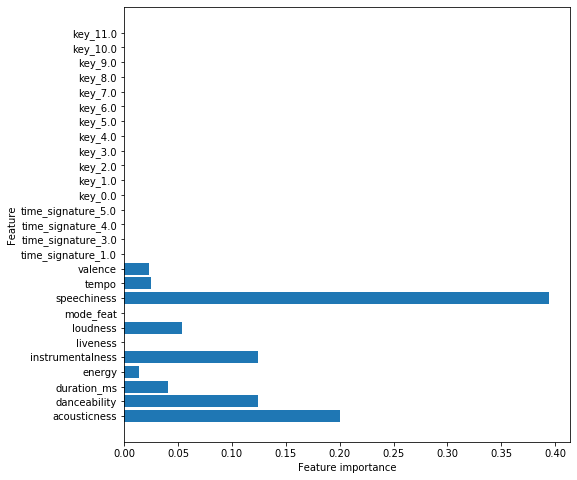

In [26]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(tree_clf);

## Random Forest

In [57]:
classes = ['Dance-Pop','Rap-Pop','Folk-Pop', 'Electro-Pop','Rock-Pop', 'Indie-Pop','EDM-Pop']

In [67]:
from sklearn.ensemble import RandomForestClassifier


forest = RandomForestClassifier(n_estimators=100, 
                                max_depth= 5, 
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=11,
                                class_weight='balanced')
forest.fit(X_train, y_train)
forest.score(X_train, y_train)

pred_forest = forest.predict(X_train)
pred_forest_test = forest.predict(X_test)

print_metrics(y_train, pred_forest)
print_metrics(y_test, pred_forest_test)

# cm = confusion_matrix(y_train, pred_forest)
# print(classification_report(y_train, pred_forest))


# conf_matrix = pd.DataFrame(cm, index=['actual dancepop',
#                                       'actual poprap',
#                                       'actual folkpop', 
#                                       'actual electropop',
#                                       'actual poprock',
#                                       'actual indiepop',
#                                       'actual popedm'],
#                            columns= classes)
# conf_matrix


Accuracy Score: 0.5205890763511581
Accuracy Score: 0.5158707463540178


In [31]:
# Print metrics
from sklearn.metrics import accuracy_score

def print_metrics(labels, preds):
   print("Accuracy Score: {}".format(accuracy_score(labels, preds)))

print_metrics(y_train, pred_forest)

Accuracy Score: 0.5205890763511581


In [32]:
test_forest = forest.predict(X_test)
print_metrics(y_test, test_forest)

Accuracy Score: 0.5158707463540178


## Grid Search for best parameters

In [73]:
from sklearn.model_selection import GridSearchCV


forest_GS = RandomForestClassifier(random_state = 11,
                                   bootstrap=True,
                                   n_jobs=-1,
                                   oob_score=True,
                                   class_weight='balanced')

 
# Set grid search params
param_grid_forest = [ 
  {'n_estimators': [ 225, 250, 275, 300],
   'criterion': ['entropy'], 
   'max_depth': [6, 8],  
   'min_samples_leaf':[ 1, 10, 20]  
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=forest_GS,
            param_grid=param_grid_forest,
            scoring='accuracy',
            refit='accuracy',
            cv=5, verbose=2, return_train_score = True,
            n_jobs=-1)

# Fit using grid search
gs_rf.fit(X_train, y_train)


pred_gs_rf_train = gs_rf.predict(X_train)
pred_gs_rf_test = gs_rf.predict(X_test)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.2min finished


Best accuracy: 0.533

Best params:
 {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 225}


In [74]:
print("Train score:")
print_metrics(y_train, pred_gs_rf_train)

print("Test score:")
print_metrics(y_test, pred_gs_rf_test)

Train score:
Accuracy Score: 0.6046611381183872
Test score:
Accuracy Score: 0.5416070917929654


#### Confusion Matrix

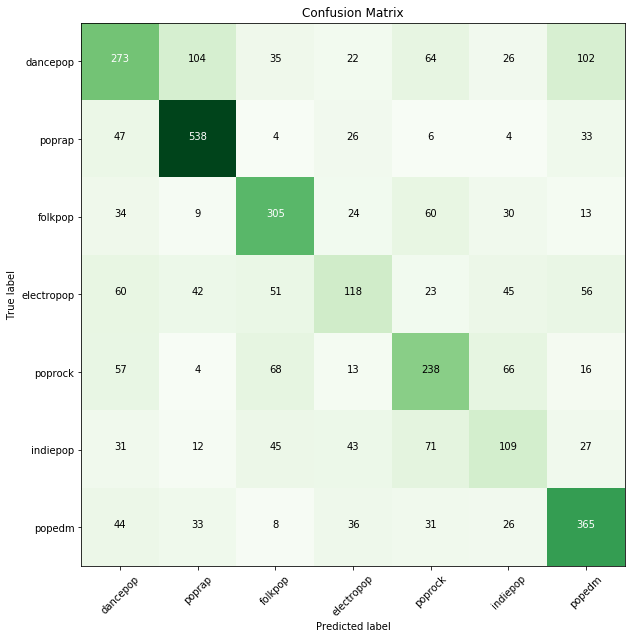

In [55]:
import itertools 

cnf_matrix = confusion_matrix(y_test, pred_gs_rf_test)
sns.set(font_scale=1.5)
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix,  cmap=plt.cm.Greens)  # Create the basic matrix.

# Add title and Axis Labels
# plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate Axis Scales
class_names = classes  # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add Labels to Each Cell
thresh = cnf_matrix.max() / 2.  # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")


### Take out key, time signature, mode_feat, and liveness features

In [38]:
train.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode_feat', 'speechiness', 'tempo', 'valence', 'time_signature_1.0', 'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0', 'key_0.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0', 'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0', 'key_11.0', 'target'], dtype='object')

In [56]:
X_train2 = train[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']]
y_train2 = train['target']

X_test2 = test[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']]
y_test2 = test['target']

X_test_final_2 = test_final[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']]
y_test_final_2 = test_final['target']


### "Normal" Random Forest

In [51]:
forest2 = RandomForestClassifier(n_estimators=100, 
                                max_depth= 5, 
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=11,
                                class_weight='balanced')
forest2.fit(X_train2, y_train2)
forest2.score(X_train2, y_train2)

pred_forest2 = forest2.predict(X_train2)
pred_forest_test2 = forest2.predict(X_test2)

print("Train score:")
print_metrics(y_train2, pred_forest2)
print("Test score:")
print_metrics(y_test2, pred_forest_test2)


Accuracy Score: 0.5157992565055762
Accuracy Score: 0.5072919645410352


### Tuning Random Forest Parameters using Grid Search and Cross Validation

In [63]:
forest_GS2 = RandomForestClassifier(random_state = 11,
                                   bootstrap=True,
                                   n_jobs=-1,
                                   oob_score=True,
                                   class_weight='balanced')

 
# Set grid search params
param_grid_forest = [ 
  {'n_estimators': [225, 250, 275],
   'criterion': ['entropy', 'gini'], 
   'max_depth': [6, 8],  
#    'min_samples_leaf':[ 1, 2],  
   'min_samples_split':[3, 4]
  }
]

# Construct grid search
gs_rf2 = GridSearchCV(estimator=forest_GS2,
            param_grid=param_grid_forest,
            scoring='accuracy',
            refit='accuracy',
            cv=5, verbose=2, return_train_score = True,
            n_jobs=-1)

# Fit using grid search
gs_rf2.fit(X_train2, y_train2)


pred_gs_rf_train2 = gs_rf2.predict(X_train2)
pred_gs_rf_test2 = gs_rf2.predict(X_test2)



best_parameters2 = gs_rf2.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters2.keys()):
    print("%s: %r" % (param_name, best_parameters2[param_name]))
    

# Best accuracy
print('Best accuracy: %.3f' % gs_rf2.best_score_)

# Best params
print('\nBest params:\n', gs_rf2.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.3min finished


Grid Search found the following optimal parameters: 
criterion: 'entropy'
max_depth: 8
min_samples_split: 4
n_estimators: 250
Best accuracy: 0.533

Best params:
 {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 250}


In [64]:
print("Train score:")
print_metrics(y_train2, pred_gs_rf_train2)
    
print("Test score:")
print_metrics(y_test2, pred_gs_rf_test2)

Train score:
Accuracy Score: 0.6023734629682586
Test score:
Accuracy Score: 0.5333142693737489
